# Official stations data

In this notebook, we will assemble a time series of meteorological measurements from meteorological stations in the study region. We will follow these steps:
1. Given a target year, use the Agrometeo API to select the temporal range of interest as the hottest heatwave, defined as follows: the hottest (based on mean temperature) period of at least 3 consecutive days with an average temperature over 27$^{\circ}$C (namely, the hottest period of level 4 warning days [according to the heat warning level definitions by MeteoSwiss](https://www.meteoswiss.admin.ch/weather/weather-and-climate-from-a-to-z/heat-warnings.html)).
2. Given the temporal range of interest obtained above, download the time series of meteorological measurements from the other official meteorological stations in the study region.
3. Resample all data to hourly resolution, assemble into a single long data frame and dump into a file

In [ ]:
from datetime import datetime, timedelta

import geopandas as gpd
import pandas as pd
import seaborn as sns
from meteostations.clients import agrometeo
from shapely import geometry

from uhi_drivers_lausanne import official_stations_utils, plot_utils

HEATWAVE_N_CONSECUTIVE_DAYS = 3
HEATWAVE_THRESHOLD = 27

NETATMO_SCALE = "1hour"  # could also be "30min"

ERROR 1: PROJ: proj_create_from_database: Open of /home/martibosch/mambaforge/envs/uhi-drivers-lausanne/share/proj failed
/home/martibosch/mambaforge/envs/uhi-drivers-lausanne/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# spatial extent
agglom_extent_filepath = "../data/raw/agglom-extent.gpkg"

# files to write
dst_ts_df_filepath = "../data/processed/official-ts-df.csv"
dst_stations_gdf_filepath = "../data/processed/official-stations.gpkg"

# select study period
year = 2023
days_before = 1
days_after = 1

# S3 data
bucket_name = "ceat-data"
idaweb_key = "meteoswiss/idaweb/lausanne-08-2023.txt"
vaudair_key = "vaud-air/VaudAir_AggloLausanne_20220101-20231231_20240613.xlsx"

# station locations
station_location_filepath = (
    "https://zenodo.org/record/4384675/files/station-locations.csv"
)
station_location_crs = "epsg:2056"

## 1. Select study period

We will use the Agrometeo API to select the hottest heatwave period as described above.

<Axes: xlabel='time'>

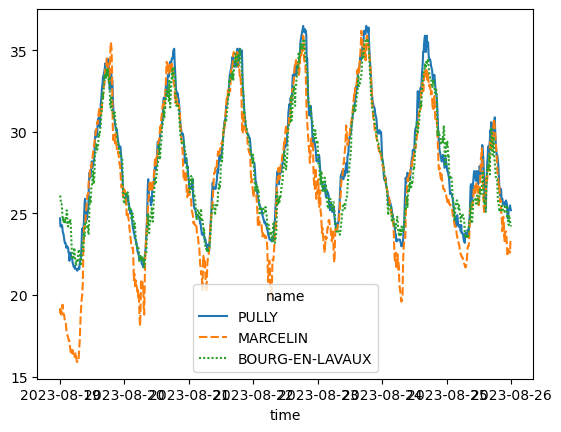

In [ ]:
# select only land extent (agglom_extent_filepath has two geometries: land and lake)
region = gpd.read_file(agglom_extent_filepath)["geometry"].iloc[:1]

# download data
agrometeo_ts_df = agrometeo.AgrometeoClient(region=region).get_ts_df(
    variable="temperature", start_date=f"01-01-{year}", end_date=f"31-12-{year}"
)

# find consecutive days above threshold
day_max_ts_ser = (
    agrometeo_ts_df.groupby(agrometeo_ts_df.index.date).mean().mean(axis="columns")
)
idx = (day_max_ts_ser >= HEATWAVE_THRESHOLD).rolling(
    window=HEATWAVE_N_CONSECUTIVE_DAYS, center=True
).sum() >= HEATWAVE_N_CONSECUTIVE_DAYS
idx = idx | idx.shift(1) | idx.shift(-1)

heatwave_max_ser = pd.concat(
    [
        pd.Series(day_max_ts_ser.loc[g[g].index].mean(), index=g.index)
        for i, g in idx.groupby(idx.ne(idx.shift()).cumsum())
        if g.any()
    ]
)
heatwave_start = datetime.combine(
    heatwave_max_ser.idxmax(), datetime.min.time()
) - timedelta(days=days_before)
heatwave_end = datetime.combine(
    heatwave_max_ser[::-1].idxmax(), datetime.max.time()
) + timedelta(days=days_after)

# filter data by study period
agrometeo_ts_df = agrometeo_ts_df.loc[heatwave_start:heatwave_end]
sns.lineplot(agrometeo_ts_df)

## 2. Get data from other official stations

Download the data from a private S3 bucket.

In [ ]:
client = official_stations_utils.SpacesClient(bucket_name=bucket_name)

### 2.1 IDAWEB

<Axes: xlabel='time'>

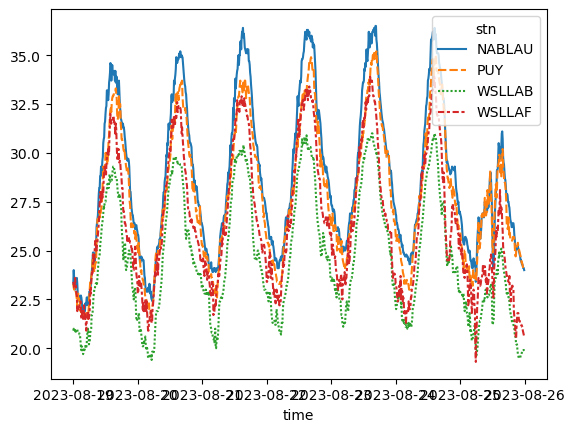

In [ ]:
idaweb_ts_df = client.get_idaweb_df(idaweb_key).loc[heatwave_start:heatwave_end]
sns.lineplot(idaweb_ts_df)

### 2.2 Vaud'air

<Axes: xlabel='time'>

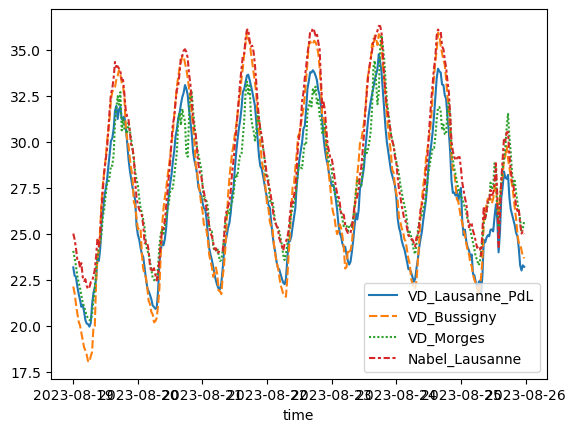

In [ ]:
# select the first four columns (the other ones are humidity)
vaudair_ts_df = (
    client.get_vaudair_df(vaudair_key, sheet_name=str(year))
    .loc[heatwave_start:heatwave_end]
    .iloc[:, :4]
)
sns.lineplot(vaudair_ts_df)

## 3. Resample and assemble

In [ ]:
official_ts_df = pd.concat(
    [
        ts_df.resample("H")
        .mean()
        .rename_axis("station", axis="columns")
        .stack()
        .rename("temperature")
        .reset_index()
        for ts_df in [agrometeo_ts_df, idaweb_ts_df, vaudair_ts_df]
    ]
)
# convert to wide format
official_ts_df = official_ts_df.pivot_table(index="time", columns="station", values="temperature")
official_ts_df.head()

station,BOURG-EN-LAVAUX,MARCELIN,NABLAU,Nabel_Lausanne,PULLY,PUY,VD_Bussigny,VD_Lausanne_PdL,VD_Morges,WSLLAB,WSLLAF
time,,,,,,,,,,,
2023-08-19 00:00:00,25.633333,19.100000,23.400000,24.861652,24.316667,23.066667,21.9510,22.9550,23.8880,20.933333,23.300000
2023-08-19 01:00:00,24.583333,18.816667,23.133333,23.901738,23.566667,22.583333,20.9350,22.4010,22.9805,20.883333,22.433333
2023-08-19 02:00:00,24.766667,17.900000,22.533333,23.375931,23.016667,22.283333,20.1255,21.5830,22.2120,20.600000,22.233333
2023-08-19 03:00:00,24.466667,17.116667,22.200000,23.039777,22.516667,21.733333,19.4265,21.0945,21.4515,19.916667,21.716667
2023-08-19 04:00:00,22.983333,16.583333,22.100000,22.491028,22.233333,21.633333,18.7460,20.5490,20.9300,20.016667,21.550000


<Axes: xlabel='time'>

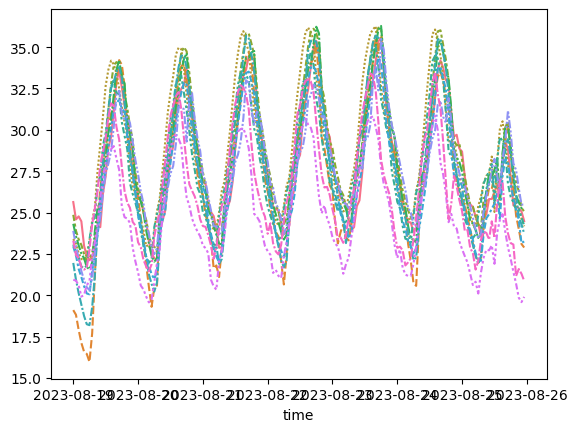

In [ ]:
sns.lineplot(official_ts_df, legend=False)

## 4. Station locations

In [ ]:
official_stations_gser = official_stations_utils.get_station_gser(
    station_location_filepath, station_location_crs
)
# add missing station locations by hand (TODO: change UGLY hardcoded lines)
official_stations_gser["Nabel_Lausanne"] = geometry.Point(2538690, 1152615)
# official_stations_gser["WSLLAB"] = geometry.Point(2545761, 1160617)
# set CRS lost in line above
official_stations_gser = official_stations_gser.set_crs(station_location_crs)
# filter to keep only stations in our agglomeration extent
official_stations_gser = official_stations_gser[official_stations_gser.intersects(region.iloc[0])]

<Axes: >

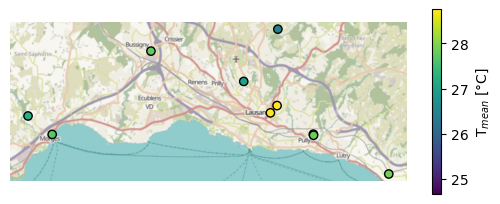

In [ ]:
# plot by average temperature
plot_kws = {"legend_kwds": {"shrink": 0.5, "label": "T$_{mean}$ [$\degree$C]"}}
plot_utils.plot_stations_by_var(
    official_stations_gser, official_ts_df.mean().rename("T_mean"), plot_kws=plot_kws
)

## Filter data and dump to files

In [ ]:
# stations to keep: stations from the time series data and within the extent
official_stations = official_stations_gser.index.intersection(official_ts_df.columns)
# filter time series data from stations of the region only
official_ts_df[official_stations].to_csv(dst_ts_df_filepath)
# filter to keep only stations in our time series data frame 
official_stations_gser.loc[official_stations].to_file(dst_stations_gdf_filepath)